In [1]:
# Importing necessary libraries for data processing and model evaluation
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [2]:
# Load dataset
tweet = pd.read_csv("Tweets.csv")
tweet.head()                

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
# Dropping unnecessary columns and removing null values
tweet.drop(['selected_text', 'textID'], axis=1, inplace=True)
tweet.dropna(inplace=True)
tweet.reset_index(drop=True, inplace=True)

In [4]:
tweet.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
# Initializing stopwords and lemmatizer
stopwords_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning and lemmatizing text using full POS tagging
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    tokens = text.split()

    # POS tag the entire sentence
    tagged_tokens = pos_tag(tokens)

    # Lemmatizing using proper POS tag for each word
    lemmatized = [
        lemmatizer.lemmatize(word, {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV
        }.get(tag[0].upper(), wordnet.NOUN))
        for word, tag in tagged_tokens
        # if word not in stopwords_set  # stopword removal skipped intentionally
    ]

    return " ".join(lemmatized)

# Applying preprocessing to text column
tweet['clean_text'] = tweet['text'].apply(clean_text)
tweet.head()

,text,sentiment,clean_text
0,"I`d have responded, if I were going",neutral,i d have respond if i be go
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego
2,my boss is bullying me...,negative,my bos be bully me
3,what interview! leave me alone,negative,what interview leave me alone
4,"Sons of ****, why couldn`t they put them on t...",negative,son of why couldn t they put them on the relea...


In [7]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)
X = vectorizer.fit_transform(tweet['clean_text'])

In [8]:
# Encoding sentiment labels to numerical values
y = tweet['sentiment'] 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [9]:
# Splitting the dataset into training and testing and training logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state= 45)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [10]:
# Evaluating model performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Accuracy: 0.7045
              precision    recall  f1-score   support

    negative       0.75      0.63      0.68      1159
     neutral       0.64      0.76      0.69      1668
    positive       0.79      0.71      0.74      1295

    accuracy                           0.70      4122
   macro avg       0.72      0.70      0.71      4122
weighted avg       0.71      0.70      0.71      4122



<Figure size 600x600 with 0 Axes>

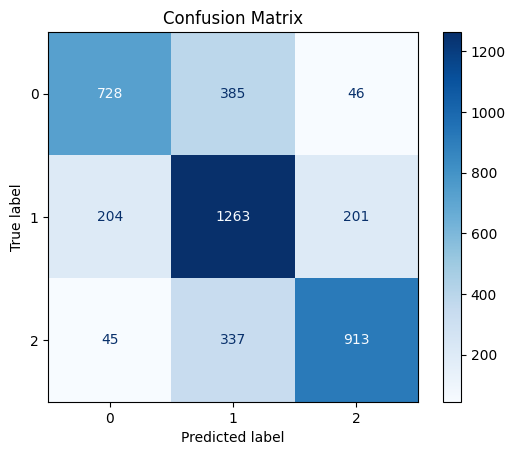

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you already have your true labels and predictions
# y_test = true labels
# y_pred = predicted labels

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [12]:
# Saving model, vectorizer, encoder, and accuracy score using joblib
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(encoder, "label_encoder.pkl")
joblib.dump(accuracy, "model_accuracy.pkl")

['model_accuracy.pkl']

In [16]:
# Test prediction on a new sample input
text = "today's weather is so good"
clean = clean_text(text)
vect = vectorizer.transform([clean])
pred = model.predict(vect)
print(pred)
print(encoder.inverse_transform(pred))

[2]
['positive']
